In [14]:
import nibabel as nib
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import glob
import random
import os

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

#from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from distutils.dir_util import copy_tree
#import gzip
#import shutil

In [ ]:
print(len(os.listdir('BraTS2021_Training_Data/')))

1251


In [ ]:
# rozdelim to na 60%, 20%, 20%

def split_data(SOURCE, TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
  for i, filename in enumerate(os.listdir(SOURCE)):
    if i <= 751:
      data_dir = TRAINING_DIR + filename
    elif i > 751 and i <= 1001:
      data_dir = VALIDATION_DIR + filename
    elif i > 1001 and i <= 1251:
      data_dir = TESTING_DIR + filename

    try:
        print(data_dir)
        os.mkdir(data_dir)
    except OSError: pass
    copy_tree(SOURCE + filename, data_dir)

In [ ]:
def split_data(SOURCE, TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
  for i, filename in enumerate(os.listdir(SOURCE)):
    if i <= 751:
      data_dir = TRAINING_DIR + filename
    elif i > 751 and i <= 1001:
      data_dir = VALIDATION_DIR + filename
    elif i > 1001 and i <= 1251:
      data_dir = TESTING_DIR + filename

    try:
        print(data_dir)
        os.mkdir(data_dir)
    except OSError: pass
    copy_tree(SOURCE + filename, data_dir)

In [ ]:
split_data('BraTS2021_Training_Data/', 'BraTS2021_Training/', 'BraTS2021_Validation/', 'BraTS2021_Testing/')

In [ ]:
print(len(os.listdir('BraTS2021_Training')))
print(len(os.listdir('BraTS2021_Validation')))
print(len(os.listdir('BraTS2021_Testing')))

# Spracovanie dát

## Ukážka dát

In [16]:
scaler = MinMaxScaler()

TRAIN_DATASET_PATH = 'BraTS2021_Training/'
VALIDATION_DATASET_PATH = 'BraTS2021_Validation/'
TEST_DATASET_PATH = 'BraTS2021_Testing/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01453/BraTS2021_01453_flair.nii.gz').get_fdata()
print(test_image_flair.max())

# Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01453/BraTS2021_01453_t1.nii.gz').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH +'BraTS2021_01453/BraTS2021_01453_t1ce.nii.gz').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01453/BraTS2021_01453_t2.nii.gz').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01453/BraTS2021_01453_seg.nii.gz').get_fdata()
test_mask=test_mask.astype(np.uint8)

# 0..4 su oznacenia toho nadora, kde O je vsetko, 1 je NCR, 2 je ED, 3 nie je nic a 4 je ET
print(np.unique(test_mask))
test_mask[test_mask==4] = 3  # tu sa posunie ta 4 namiesto 3, lebo aj tak tam nic nie je 
print(np.unique(test_mask)) 

800.0
[0 1 2 4]
[0 1 2 3]


Tu len randomne vyberá časti, aby ukázal, že tam je veľa zbytočného

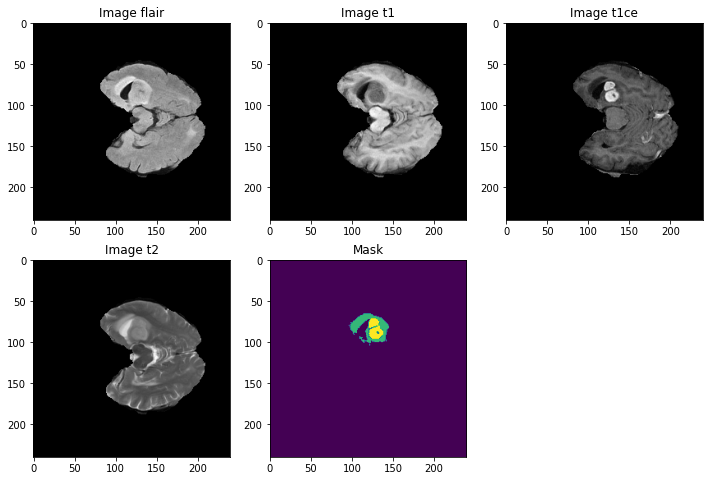

(240, 240, 155)

In [17]:
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()
test_image_flair.shape

Spojí tie 4 (flair, t1, t1ce a t2) alebo 3 (t1, nemá takú výpovednú hodnotu) časti

In [ ]:
##################################################
# PART 2: Explore the process of combining images to channels and divide them to patches
# Includes...
# Combining all 4 images to 4 channels of a numpy array.
#
################################################
# Flair, T1CE, annd T2 have the most information
# Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce], axis=3)
combined_x.shape

(240, 240, 155, 2)

Cropne tie dáta, pretože na veľa z nich nič nie je

In [ ]:
# Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
# cropping x, y, and z
# combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] # Crop to 128x128x128x4

# Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

print(test_mask.shape)
print(combined_x.shape)

#plt.imshow(combined_x[:,:,n_slice,0], cmap='gray')

(128, 128, 128)
(128, 128, 128, 2)


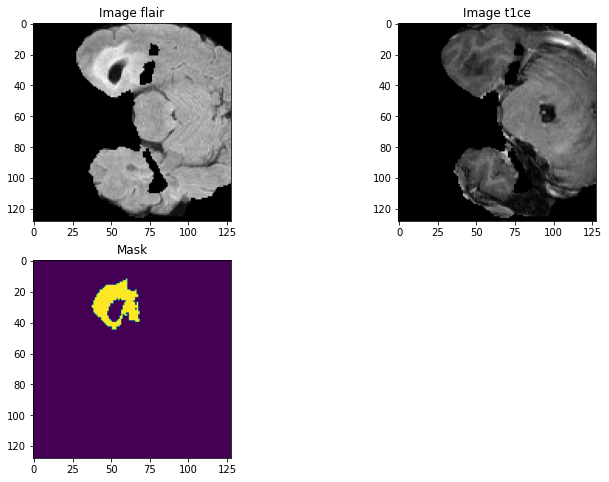

In [ ]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Tu si uloží tie dáta, nie je to potrebné

In [ ]:
imsave('BraTS2021_Training/combined01453.tif', combined_x)
np.save('BraTS2021_Training/combined01453.npy', combined_x)
# Verify image is being read properly
# my_img=imread('BraTS2021_Training/combined01453.tif')

my_img=np.load('BraTS2021_Training/combined01453.npy')

test_mask = to_categorical(test_mask, num_classes=4)

## Samotné spracovanie

Tu si uloží názvy tých súborov, s dátami

In [6]:
# Now let us apply the same as above to all the images...
# Merge channels, crop, patchify, save
# GET DATA READY =  GENERATORS OR OTHERWISE

# Keras datagenerator does ntot support 3d

# # # images lists harley
t2_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*t2.nii.gz'))
t1ce_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*t1ce.nii.gz'))
flair_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*flair.nii.gz'))
mask_list = sorted(glob.glob(TRAIN_DATASET_PATH + '/*/*seg.nii.gz'))

In [ ]:
print(len(t2_list))

752


In [ ]:
!ls skusobny2/input_data_3channels/images/

In [ ]:
for img in range(len(t2_list)//2):   # Using t2_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    #temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    #temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  # Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce], axis=3) # tu len treba vyhodit jedno 
    
    # Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    # cropping x, y, and z
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    # ulozi tie data, ak ma maska aspon 1% oznacene
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #A t least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask=to_categorical(temp_mask, num_classes=4)
        np.save('skusobny2/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('skusobny2/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")   

In [ ]:
#!pip install split-folders
import splitfolders  # https://pypi.org/project/split-folders/

input_folder = 'skusobny2/input_data_3channels/'
output_folder = 'skusobny2/input_data_128/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.60, .20, .20), group_prefix=None) # default values
#splitfolders.fixed(input_folder, output=output_folder, seed=42, fixed=(260, 70, 70), oversample=False, group_prefix=None)

# Data generator

na načítanie dát/obrázkov,

ten data generátor, čo je v keras pracuje len s obrázkami (.png, .jpeg, ...)

In [18]:
def load_img(img_dir, img_list):
  images=[]
  for i, image_name in enumerate(img_list):    
    if (image_name.split('.')[1] == 'npy'):      
      image = np.load(img_dir+image_name)
      images.append(image)

  images = np.array(images)

  return(images)

In [19]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
  img_len = len(img_list)

  # keras needs the generator infinite
  while True:
    batch_start = 0
    batch_end = batch_size

    while batch_start < img_len:
      limit = min(batch_end, img_len)               
      x = load_img(img_dir, img_list[batch_start:limit])
      y = load_img(mask_dir, mask_list[batch_start:limit])

      yield (x,y) # a tuple with two numpy arrays with batch_size samples     

      batch_start += batch_size   
      batch_end += batch_size


### Testovanie generátora

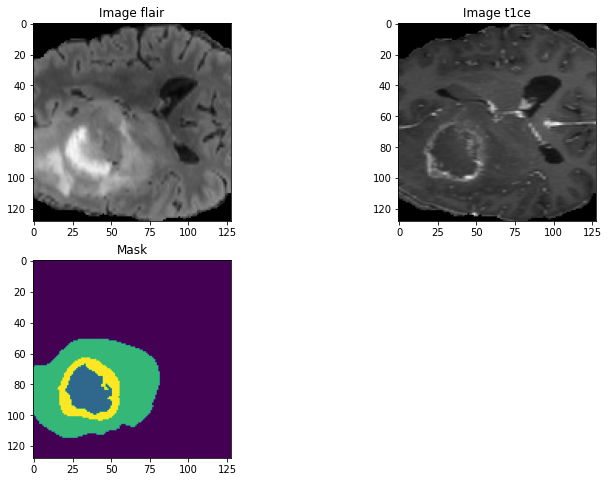

In [20]:
train_img_dir = "skusobny2/input_data_128/train/images/"
train_mask_dir = "skusobny2/input_data_128/train/masks/"
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

#n_slice=random.randint(0, test_mask.shape[2])
n_slice = 70
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# Model

## Definovanie modelu

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

kernel_initializer = 'he_uniform' # Try others if you want


def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
  #s = Lambda(lambda x: x / 255)(inputs)   # No need for this if we normalize our inputs beforehand
  s = inputs

  # Contraction path
  c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
  c1 = Dropout(0.1)(c1)
  c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
  p1 = MaxPooling3D((2, 2, 2))(c1)
  
  c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
  p2 = MaxPooling3D((2, 2, 2))(c2)
    
  c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
  p3 = MaxPooling3D((2, 2, 2))(c3)
    
  c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
  p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
    
  c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
  
  # Expansive path 
  u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
    
  u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
    
  u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
    
  u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1])
  c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
    
  outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
    
  model = Model(inputs=[inputs], outputs=[outputs])
  # compile model outside of this function to make it flexible. 
  model.summary()
  
  return model

# Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 2, 4) # povodne tu bolo (128, 128, 128, 3, 4)
#print(model.input_shape)
#print(model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 2)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  880         ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

In [22]:
'''
Images are expected to be 128x128x128x3 npy data (3 corresponds to the 3 channels for 
                                                  test_image_flair, test_image_t1ce, test_image_t2)
Change the U-net input shape based on your input dataset shape (e.g. if you decide to only se 2 channels or all 4 channels)
Masks are expected to be 128x128x128x4 npy data (4 corresponds to the 4 classes / labels)
'''

train_img_dir = "skusobny2/input_data_128/train/images/"
train_mask_dir = "skusobny2/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

Otestovanie, či to funguje 

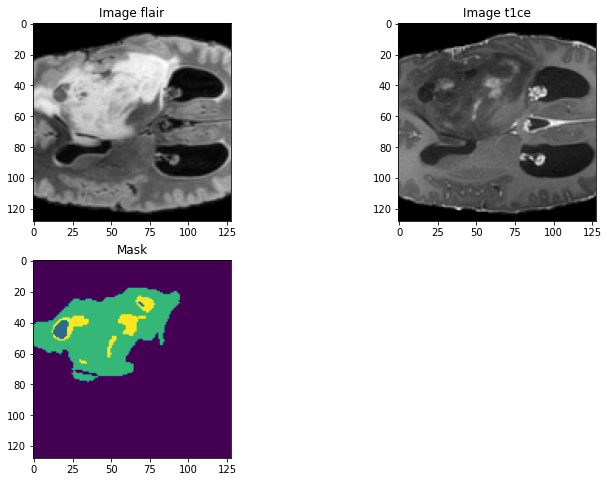

In [26]:
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Definovanie tých generátorov pre **trénovanie** a **validáciu**

In [27]:
train_img_dir = "skusobny2/input_data_128/train/images/"
train_mask_dir = "skusobny2/input_data_128/train/masks/"

val_img_dir = "skusobny2/input_data_128/val/images/"
val_mask_dir = "skusobny2/input_data_128/val/masks/"

train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

Definovanie batch size a data generátora

In [28]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

Znovu testovanie

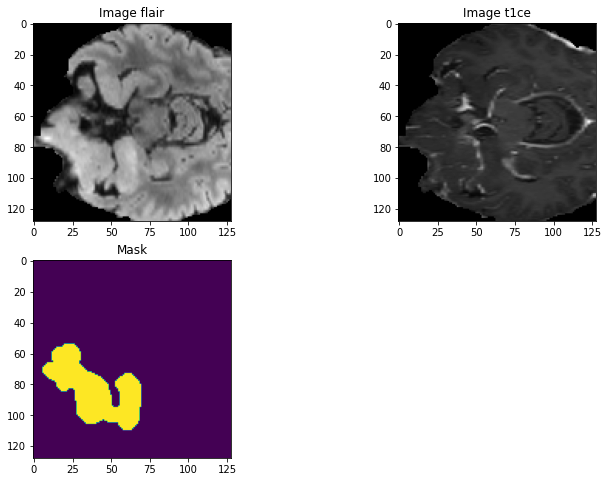

In [29]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [30]:
import keras.backend as K

# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)


Definovanie loss a optimizer

In [31]:
#!pip install segmentation-models-3D
#!pip install keras_applications
import segmentation_models_3D as sm

# Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

#metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
metrics = ['accuracy',sm.metrics.IOUScore(threshold=0.5), tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

     |████████████████████████████████| 46 kB 3.3 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
     |████████████████████████████████| 462 kB 32.1 MB/s 
Segmentation Models: using `tf.keras` framework.


## Trénovanie

In [ ]:
from keras.models import load_model
my_model = load_model('brats_3d.h5', custom_objects={'dice_loss': dice_loss, 'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [32]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=2, 
                          num_classes=4)

model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

#print(model.summary())
#print(model.input_shape)
#print(model.output_shape)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 2)]                                                           
                                                                                                  
 conv3d_38 (Conv3D)             (None, 128, 128, 12  880         ['input_3[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_18 (Dropout)           (None, 128, 128, 12  0           ['conv3d_38[0][0]']              
                                8, 16)                                                      

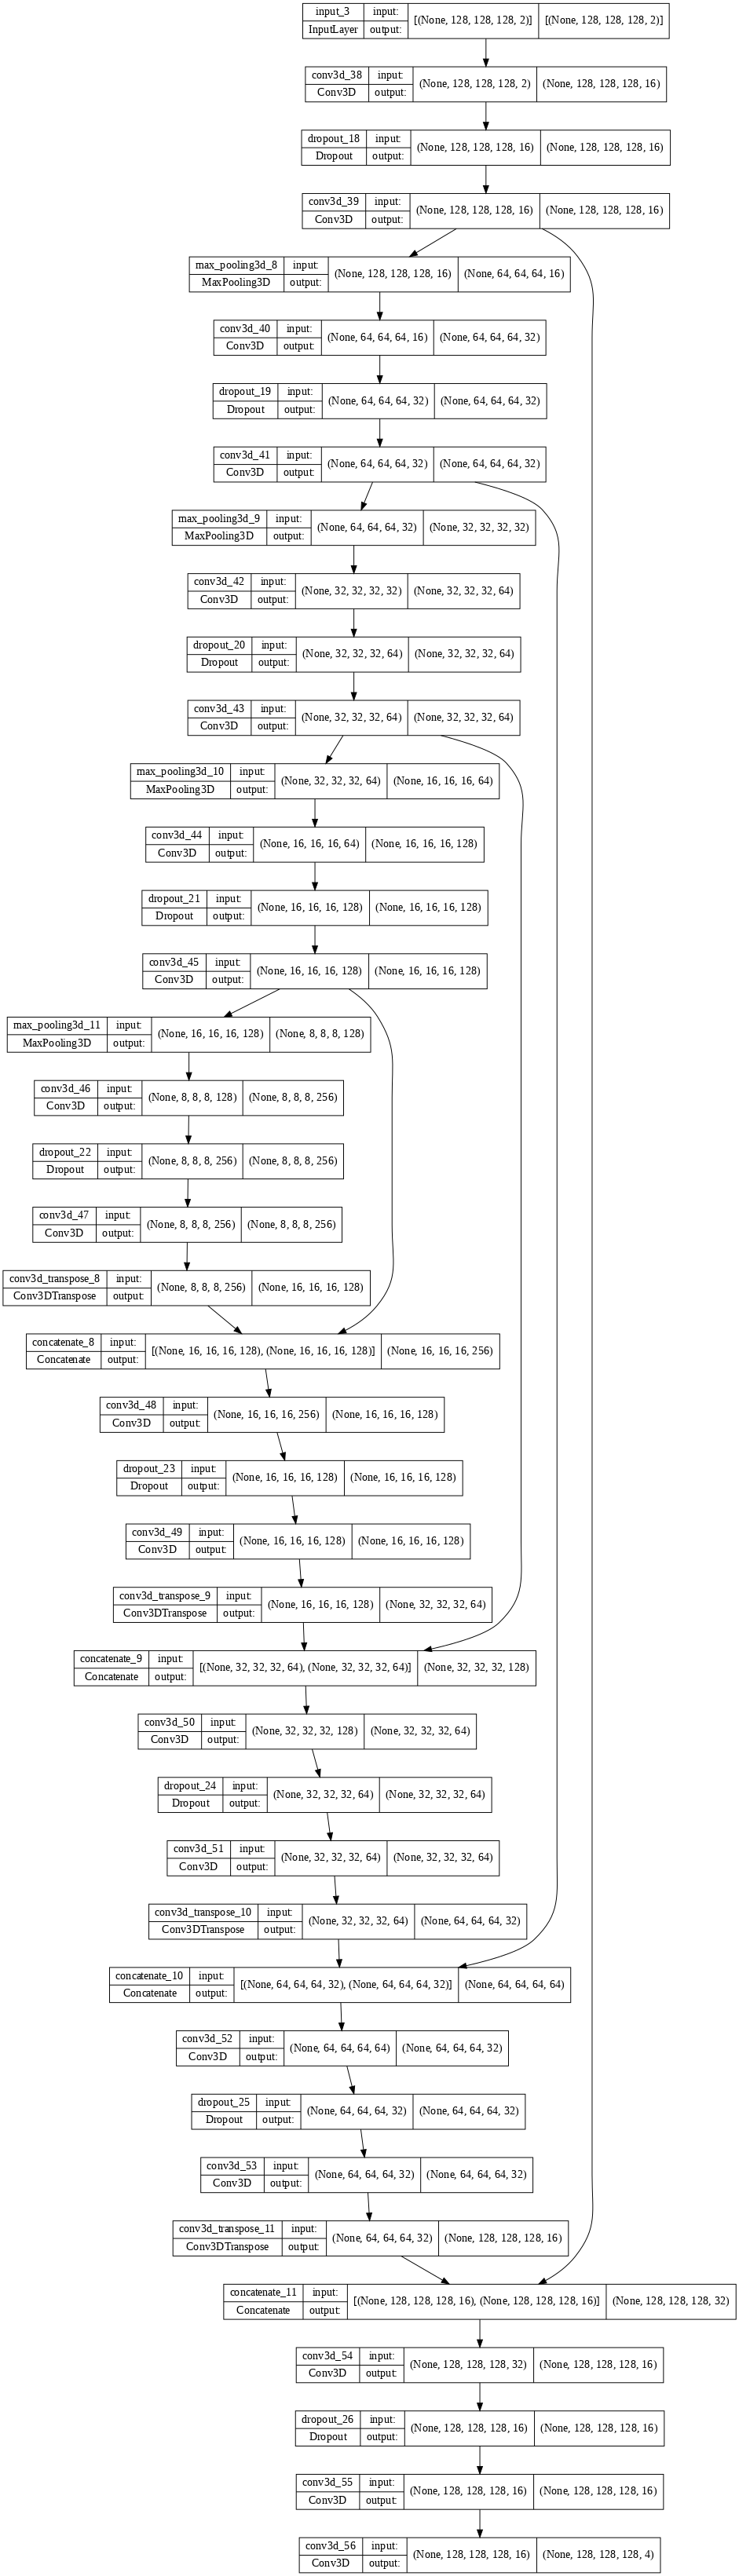

In [33]:
from tensorflow.keras.utils import plot_model
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

Callback

In [34]:
from keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

csv_logger = CSVLogger('training.log', separator=',', append=False)

callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=2, verbose=1, mode='auto'),
             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1),
             keras.callbacks.ModelCheckpoint(filepath = 'checkpoints/model_.{epoch:02d}-{val_loss:.6f}.m5',
                                             verbose=1, save_best_only=True, save_weights_only = True),
             csv_logger]

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=30,
          verbose=1,
          callbacks=callbacks,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch)

model.save('brats_3d.h5')

Epoch 1/30
104/104 [==============================] - ETA: 0s - loss: 0.9512 - accuracy: 0.9393 - iou_score: 0.2129 - mean_io_u: 0.3967 - dice_coef: 0.3075 - dice_coef_necrotic: 0.0514 - dice_coef_edema: 0.1687 - dice_coef_enhancing: 0.0527
Epoch 1: val_loss improved from inf to 0.95215, saving model to checkpoints/model_.01-0.952147.m5
104/104 [==============================] - 597s 5s/step - loss: 0.9512 - accuracy: 0.9393 - iou_score: 0.2129 - mean_io_u: 0.3967 - dice_coef: 0.3075 - dice_coef_necrotic: 0.0514 - dice_coef_edema: 0.1687 - dice_coef_enhancing: 0.0527 - val_loss: 0.9521 - val_accuracy: 0.8219 - val_iou_score: 0.1860 - val_mean_io_u: 0.3750 - val_dice_coef: 0.3428 - val_dice_coef_necrotic: 0.0860 - val_dice_coef_edema: 0.2638 - val_dice_coef_enhancing: 0.1115 - lr: 1.0000e-04
Epoch 2/30
104/104 [==============================] - ETA: 0s - loss: 0.9295 - accuracy: 0.9467 - iou_score: 0.2870 - mean_io_u: 0.4617 - dice_coef: 0.3881 - dice_coef_necrotic: 0.0878 - dice_coef_e

In [ ]:
import pickle

with open('trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

## Záver z trénovania

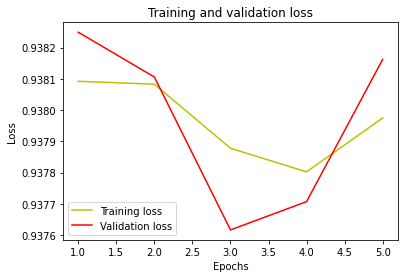

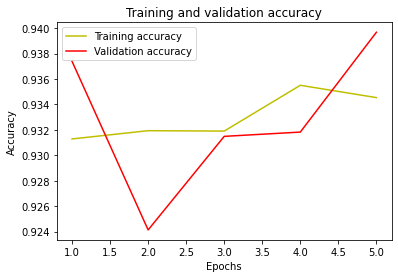

In [ ]:
# plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

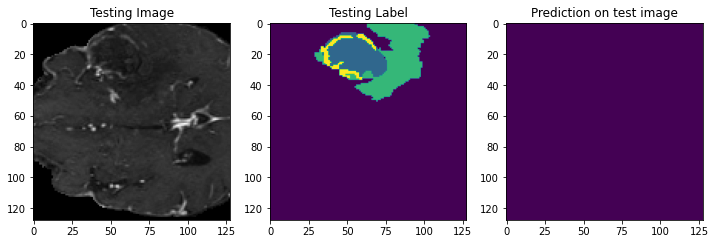

In [ ]:
img_num = 100

test_img = np.load("skusobny2/input_data_128/test/images/image_"+str(img_num)+".npy")

test_mask = np.load("skusobny2/input_data_128/test/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()